In [1]:
import os
import torch
import torchvision
import torchvision.datasets as datasets

# Maps integer class index to human-readable string describing the class
class_map = {
0 : "t-shirt",
1 : "trouser",
2 : "pullover",
3 : "dress",
4 : "coat",
5 : "sandal",
6 : "shirt",
7 : "sneaker",
8 : "bag",
9 : "ankle boot"
}

# Downloads the Fashion MNIST dataset using Torchvision
raw_dataset = datasets.FashionMNIST(
  os.path.join("/tmp/fashionmnist"),
  train=True,
  download=True)

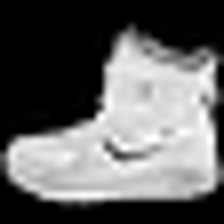

ankle boot


In [2]:
img_index = 0
tup = raw_dataset[img_index]
display(tup[0].resize((224, 224)))
print(class_map[tup[1]])

## Accuracy vs MEC

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.models import *
from typing import Any
from torch.hub import load_state_dict_from_url


model_urls = {
    "alexnet": "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth",
}


class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5, fc_parameter: int = 4096) -> None:
        super().__init__()
        _log_api_usage_once(self)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            #nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, fc_parameter),
            nn.ReLU(inplace=True),
            #nn.Dropout(p=dropout),
            nn.Linear(fc_parameter, fc_parameter),
            nn.ReLU(inplace=True),
            nn.Linear(fc_parameter, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> AlexNet:
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    The required minimum input size of the model is 63x63.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls["alexnet"], progress=progress)
        model.load_state_dict(state_dict)
    return model

def _log_api_usage_once(obj: str) -> None:  # type: ignore
    if torch.jit.is_scripting() or torch.jit.is_tracing():
        return
    # NOTE: obj can be an object as well, but mocking it here to be
    # only a string to appease torchscript
    if isinstance(obj, str):
        torch._C._log_api_usage_once(obj)
    else:
        torch._C._log_api_usage_once(f"{obj.__module__}.{obj.__class__.__name__}")

In [4]:
import torchvision.transforms as transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_rgb = transforms.Lambda(lambda image: image.convert('RGB'))
resize = transforms.Resize((224, 224))
my_transform = transforms.Compose([resize, to_rgb, transforms.ToTensor(), normalize])

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
net = alexnet(num_classes=10)
net = net.to(device)

In [7]:
from torchsummary import summary
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [8]:
train_dataset = datasets.FashionMNIST(
  os.path.join("/tmp/fashionmnist"),
  train=True,
  download=True,
  transform=my_transform)

test_dataset = datasets.FashionMNIST(
  os.path.join("/tmp/fashionmnist"),
  train=False,
  download=True,
  transform=my_transform)

In [9]:
train_sampler = torch.utils.data.RandomSampler(train_dataset)
test_sampler = torch.utils.data.RandomSampler(test_dataset)

In [10]:
batch_size = 8

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    sampler=test_sampler)

In [11]:
def train_model(train_loader):
    # Note: this will take 5-10 minutes to run.
    num_epochs = 2
    loss_fn = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(net.parameters())

    # Ensures network is in train mode
    net.train()

    start_time = time.time()
    for epoch in range(num_epochs):
        for data, targets in iter(train_loader):
            # Sends data and targets to device
            data = data.to(device)
            targets = targets.to(device)

            # Acquires the network's best guesses at each class
            results = net(data)

            # Computes loss
            loss = loss_fn(results, targets)

            # Updates model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    elapsed_time = time.time() - start_time
    print ("Spent ", elapsed_time, " seconds training for ", num_epochs, " epoch(s) on a single core.")

In [12]:
import time

# Runs the given net on the batches provided by the test_loader
# Records the number of correct predictions (guesses) and 
# prints the percentage of correct guesses on the dataset, plus a 
# sample batch.
def eval_network(net, test_loader):
    start_time = time.time()
    num_correct = 0
    total_guesses = 0

    # Sets eval and no grad context for evaluation
    net.eval()
    with torch.no_grad():
        for data, targets in iter(test_loader):
            # Sends data and targets to device
            data = data.to(device)
            targets = targets.to(device)

            # Acquires the network's best guesses at each class
            results = net(data)
            best_guesses = torch.argmax(results, 1)

            # Updates number of correct and total guesses
            num_correct += torch.eq(targets, best_guesses).sum().item()
            total_guesses += batch_size

    # Prints output
    elapsed_time = time.time() - start_time
    print("Correctly guessed ", num_correct/total_guesses*100, "% of the dataset")
    print("Evaluated in ", elapsed_time, " seconds")
    return num_correct/total_guesses

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
acc_list = []
fc_parameter_list = [1024, 2048, 4096, 6144, 8192, 9216]
for i in range(len(fc_parameter_list)):
    print("fc_parameter: " + str(fc_parameter_list[i]))
    net = alexnet(num_classes=10, fc_parameter=fc_parameter_list[i])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    train_model()
    acc_list.append(eval_network(net, test_loader))

fc_parameter: 1024
Spent  333.62993240356445  seconds training for  2  epoch(s) on a single core.
Correctly guessed  84.94 % of the dataset
Evaluated in  20.345571517944336  seconds
fc_parameter: 2048
Spent  458.3123652935028  seconds training for  2  epoch(s) on a single core.
Correctly guessed  86.04 % of the dataset
Evaluated in  18.10058045387268  seconds
fc_parameter: 4096


RuntimeError: CUDA out of memory. Tried to allocate 144.00 MiB (GPU 0; 6.00 GiB total capacity; 4.43 GiB already allocated; 54.62 MiB free; 4.57 GiB reserved in total by PyTorch)

In [12]:
acc_list = []
fc_parameter_list = [4096, 6144, 8192, 9216]
for i in range(len(fc_parameter_list)):
    print("fc_parameter: " + str(fc_parameter_list[i]))
    net = alexnet(num_classes=10, fc_parameter=fc_parameter_list[i])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    train_model()
    acc_list.append(eval_network(net, test_loader))

fc_parameter: 4096
Spent  792.8754980564117  seconds training for  2  epoch(s) on a single core.
Correctly guessed  85.54 % of the dataset
Evaluated in  18.654101371765137  seconds
fc_parameter: 6144
Spent  1219.6902849674225  seconds training for  2  epoch(s) on a single core.
Correctly guessed  85.22 % of the dataset
Evaluated in  20.297701835632324  seconds
fc_parameter: 8192
Spent  1739.4681255817413  seconds training for  2  epoch(s) on a single core.
Correctly guessed  84.84 % of the dataset
Evaluated in  22.60176682472229  seconds
fc_parameter: 9216
Spent  2032.6720435619354  seconds training for  2  epoch(s) on a single core.
Correctly guessed  83.27 % of the dataset
Evaluated in  24.046509981155396  seconds


In [13]:
acc_list

[0.8554, 0.8522, 0.8484, 0.8327]

In [26]:
acc_list = [0.8604, 0.8554, 0.8522, 0.8484, 0.8327]

In [27]:
MEC = [18, 37, 56, 75, 85]

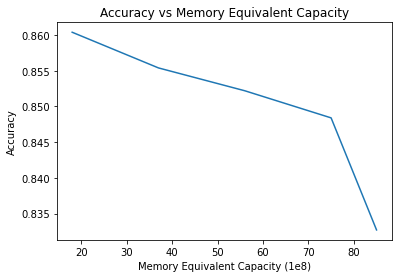

In [28]:
import matplotlib.pyplot as plt
plt.plot(MEC, acc_list)
plt.xlabel("Memory Equivalent Capacity (1e8)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Memory Equivalent Capacity");

## Data Augmentation

In [61]:
new_transform=transforms.Compose([
    resize,to_rgb,
    #transforms.RandomRotation(360)
    transforms.RandomHorizontalFlip(1),#Data Augmentation
    #transforms.RandomVerticalFlip(1),
    transforms.ToTensor(),
    normalize
])

In [62]:
new_train_dataset = datasets.FashionMNIST(
  os.path.join("/tmp/fashionmnist"),
  train=True,
  download=True,
  transform=my_transform)

In [63]:
indices = torch.randperm(len(new_train_dataset))[:1000]

In [64]:
new_train_dataset_part = torch.utils.data.Subset(new_train_dataset, indices)

In [65]:
new_train_sampler = torch.utils.data.RandomSampler(new_train_dataset_part)

In [66]:
batch_size = 8

new_train_loader = torch.utils.data.DataLoader(
    new_train_dataset_part,
    batch_size=batch_size,
    sampler=new_train_sampler)

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [68]:
def new_train_model():
    # Note: this will take 5-10 minutes to run.
    num_epochs = 2
    loss_fn = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(net.parameters())

    # Ensures network is in train mode
    net.train()

    start_time = time.time()
    for epoch in range(num_epochs):
        for data, targets in iter(train_loader):
            # Sends data and targets to device
            data = data.to(device)
            targets = targets.to(device)

            # Acquires the network's best guesses at each class
            results = net(data)

            # Computes loss
            loss = loss_fn(results, targets)

            # Updates model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        for data, targets in iter(new_train_loader):
            # Sends data and targets to device
            data = data.to(device)
            targets = targets.to(device)

            # Acquires the network's best guesses at each class
            results = net(data)

            # Computes loss
            loss = loss_fn(results, targets)

            # Updates model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          
    elapsed_time = time.time() - start_time
    print ("Spent ", elapsed_time, " seconds training for ", num_epochs, " epoch(s) on a single core.")

In [38]:
acc_list = []
fc_parameter_list = [2048,4096, 6144, 8192, 9216]
for i in range(len(fc_parameter_list)):
    print("fc_parameter: " + str(fc_parameter_list[i]))
    net = alexnet(num_classes=10, fc_parameter=fc_parameter_list[i])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    new_train_model()#60000+3000flip(1)
    acc_list.append(eval_network(net, test_loader))

fc_parameter: 2048
Spent  492.0885593891144  seconds training for  2  epoch(s) on a single core.
Correctly guessed  86.49 % of the dataset
Evaluated in  21.29077172279358  seconds
fc_parameter: 4096
Spent  840.6033322811127  seconds training for  2  epoch(s) on a single core.
Correctly guessed  81.2 % of the dataset
Evaluated in  21.949993133544922  seconds
fc_parameter: 6144
Spent  1285.3284537792206  seconds training for  2  epoch(s) on a single core.
Correctly guessed  84.67 % of the dataset
Evaluated in  23.57883095741272  seconds
fc_parameter: 8192
Spent  1821.9800081253052  seconds training for  2  epoch(s) on a single core.
Correctly guessed  10.0 % of the dataset
Evaluated in  24.94459080696106  seconds
fc_parameter: 9216


RuntimeError: CUDA out of memory. Tried to allocate 324.00 MiB (GPU 0; 6.00 GiB total capacity; 4.60 GiB already allocated; 18.62 MiB free; 4.61 GiB reserved in total by PyTorch)

In [21]:
acc_list = []
fc_parameter_list = [2048,4096, 6144, 8192, 9216]
for i in range(len(fc_parameter_list)):
    print("fc_parameter: " + str(fc_parameter_list[i]))
    net = alexnet(num_classes=10, fc_parameter=fc_parameter_list[i])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    new_train_model()#60000+5000flip(1)
    acc_list.append(eval_network(net, test_loader))

fc_parameter: 2048
Spent  501.3942050933838  seconds training for  2  epoch(s) on a single core.
Correctly guessed  85.65 % of the dataset
Evaluated in  20.080832958221436  seconds
fc_parameter: 4096
Spent  864.4928238391876  seconds training for  2  epoch(s) on a single core.
Correctly guessed  83.28 % of the dataset
Evaluated in  20.76574730873108  seconds
fc_parameter: 6144


KeyboardInterrupt: 

In [23]:
acc_list = []
fc_parameter_list = [2048,4096, 6144, 8192, 9216]
for i in range(len(fc_parameter_list)):
    print("fc_parameter: " + str(fc_parameter_list[i]))
    net = alexnet(num_classes=10, fc_parameter=fc_parameter_list[i])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    new_train_model()#60000+2000flip(1)
    acc_list.append(eval_network(net, test_loader))

fc_parameter: 2048
Spent  485.15927934646606  seconds training for  2  epoch(s) on a single core.
Correctly guessed  86.11 % of the dataset
Evaluated in  19.341893434524536  seconds
fc_parameter: 4096
Spent  827.719514131546  seconds training for  2  epoch(s) on a single core.
Correctly guessed  84.65 % of the dataset
Evaluated in  20.876503467559814  seconds
fc_parameter: 6144
Spent  1268.1007733345032  seconds training for  2  epoch(s) on a single core.
Correctly guessed  81.89 % of the dataset
Evaluated in  23.137176513671875  seconds
fc_parameter: 8192
Spent  1804.0361444950104  seconds training for  2  epoch(s) on a single core.
Correctly guessed  10.0 % of the dataset
Evaluated in  24.537393808364868  seconds
fc_parameter: 9216


KeyboardInterrupt: 

In [22]:
acc_list = []
fc_parameter_list = [2048,4096, 6144, 8192, 9216]
for i in range(len(fc_parameter_list)):
    print("fc_parameter: " + str(fc_parameter_list[i]))
    net = alexnet(num_classes=10, fc_parameter=fc_parameter_list[i])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    new_train_model()#60000+4000flip(1)
    acc_list.append(eval_network(net, test_loader))

fc_parameter: 2048
Spent  505.5785083770752  seconds training for  2  epoch(s) on a single core.
Correctly guessed  85.61999999999999 % of the dataset
Evaluated in  21.914307117462158  seconds
fc_parameter: 4096
Spent  856.0739679336548  seconds training for  2  epoch(s) on a single core.
Correctly guessed  83.91999999999999 % of the dataset
Evaluated in  22.019162893295288  seconds
fc_parameter: 6144


KeyboardInterrupt: 

In [21]:
acc_list = []
fc_parameter_list = [2048]
for i in range(len(fc_parameter_list)):
    print("fc_parameter: " + str(fc_parameter_list[i]))
    net = alexnet(num_classes=10, fc_parameter=fc_parameter_list[i])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    new_train_model()#60000+1000flip(1)
    acc_list.append(eval_network(net, test_loader))

fc_parameter: 2048
Spent  499.59062933921814  seconds training for  2  epoch(s) on a single core.
Correctly guessed  85.8 % of the dataset
Evaluated in  18.271125316619873  seconds


In [ ]:
acc_list = []
fc_parameter_list = [2048,4096, 6144, 8192, 9216]
for i in range(len(fc_parameter_list)):
    print("fc_parameter: " + str(fc_parameter_list[i]))
    net = alexnet(num_classes=10, fc_parameter=fc_parameter_list[i])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    new_train_model()#60000+1000flip(1)
    acc_list.append(eval_network(net, test_loader))

fc_parameter: 2048


In [59]:
x_flip = [0, 2000, 3000, 4000, 5000]
acc_flip=[0.8604,0.8580, 0.8611,0.8649,0.8562, 0.8565]
acc_2048 = [0.8604,0.8604,0.8604,0.8604,0.8604,0.8604]

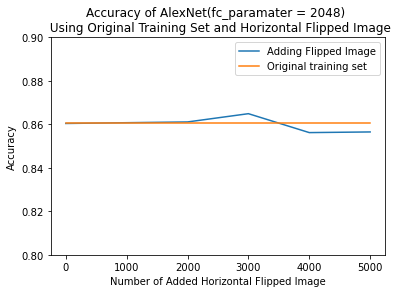

In [60]:
import matplotlib.pyplot as plt
plt.ylim(0.8, 0.9) 
plt.plot(x_flip, acc_flip, label = "Adding Flipped Image")
plt.plot(x_flip, acc_2048, label = "Original training set")
plt.legend()
plt.xlabel("Number of Added Horizontal Flipped Image")
plt.ylabel("Accuracy")
plt.title("Accuracy of AlexNet(fc_paramater = 2048) \n Using Original Training Set and Horizontal Flipped Image");